In [11]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os
import random
########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 9 # the lower limit of qubits for the circuit
upper_limit= 10 # the lower limit of qubits for the circuit
steps= 1 #jump in qubit numbers
name_of_algo='bitcode'

In [12]:
all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
selected_fakes = random.sample(all_fakes, f)
selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list

[qiskit.providers.fake_provider.backends.oslo.fake_oslo.FakeOslo,
 qiskit.providers.fake_provider.backends.belem.fake_belem.FakeBelemV2,
 qiskit.providers.fake_provider.backends.lima.fake_lima.FakeLimaV2,
 qiskit.providers.fake_provider.backends.manhattan.fake_manhattan.FakeManhattanV2,
 qiskit.providers.fake_provider.backends.melbourne.fake_melbourne.FakeMelbourneV2]

In [3]:
%%time

benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    rand_list=[]
    for j in range(i):       
        rand_list.append(random.randint(0,1))
    print("i=",i,"i-1=",i-1,"rand_list=",rand_list)
    
    benchmarks.append((supermarq.bit_code.BitCode(i,i-1,rand_list),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    print(circuit.draw())

i= 9 i-1= 8 rand_list= [0, 0, 1, 0, 1, 1, 1, 1, 1]
-------------------------- bitcode9 ---------------------------
                                                                              »
          q_0: ──■──────────────────────■─────────────────────────────────────»
               ┌─┴─┐┌───┐     ┌─┐     ┌─┴─┐     ┌───┐                         »
          q_1: ┤ X ├┤ X ├─────┤M├─|0>─┤ X ├─────┤ X ├─────────────────────────»
               └───┘└─┬─┘     └╥┘     └───┘     └─┬─┘                         »
          q_2: ──■────■────────╫─────────────■────■───────────────────────────»
               ┌─┴─┐     ┌───┐ ║  ┌─┐      ┌─┴─┐     ┌───┐                    »
          q_3: ┤ X ├─────┤ X ├─╫──┤M├──|0>─┤ X ├─────┤ X ├────────────────────»
               ├───┤     └─┬─┘ ║  └╥┘      └───┘     └─┬─┘                    »
          q_4: ┤ X ├──■────■───╫───╫──────────────■────■──────────────────────»
               └───┘┌─┴─┐┌───┐ ║   ║   ┌─┐      ┌─┴─┐     ┌───┐               »
     

In [4]:
benchmark_features = {}
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),]
print(benchmark_features)

{'bitcode9': [0.11764705882352941, 0.125, 0.9552238805970149, 0.7041522491349481, 0.2727272727272727, 0.18382352941176472]}


In [5]:
jobs =[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("------------------------BACKEND-NAME :: ", backend().name)
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        for i in range(0,5):
            job = backend().run(circuit, shots=1000)
            result=job.result()
            #print(result)
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            score_list.append(score)
        score = np.mean(score_list) 
        sd = np.std(score_list)
        print(label," --> score :: ",score,"           SD :: ",sd,"  time_taken= ",job.result(0).time_taken)
        #counts=job.result(0).count()
        jobs.append((label,benchmark,backend,job,score,sd))
#jobs

=============SCORES OF ALL THE CIRCUITS=============
------------------------BACKEND-NAME ::  fake_manhattan
bitcode9  --> score ::  1.9721522630525295e-31            SD ::  0.0   time_taken=  57.37961983680725
------------------------BACKEND-NAME ::  fake_perth
bitcode9  --> score ::  0.0            SD ::  0.0   time_taken=  51.52000570297241
------------------------BACKEND-NAME ::  fake_santiago
bitcode9  --> score ::  0.0            SD ::  0.0   time_taken=  45.39513945579529
------------------------BACKEND-NAME ::  fake_armonk
bitcode9  --> score ::  0.0            SD ::  0.0   time_taken=  42.77940893173218
------------------------BACKEND-NAME ::  fake_sherbrooke
bitcode9  --> score ::  1.9721522630525295e-31            SD ::  0.0   time_taken=  39.34269905090332


In [6]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    i={}
    for label,benchmark,backend,job,score,sd in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   

USED BACKEND:: fake_manhattan ; CIRCUIT_NAME: bitcode9 ; SCORE = 1.9721522630525295e-31


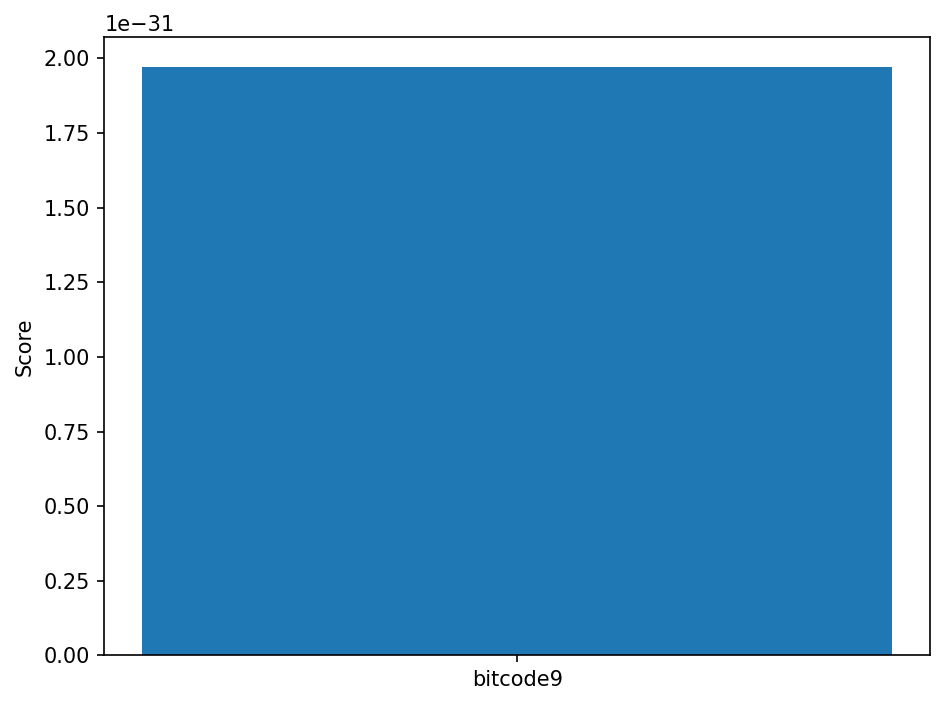

-----------------------------------------------------------
USED BACKEND:: fake_perth ; CIRCUIT_NAME: bitcode9 ; SCORE = 0.0


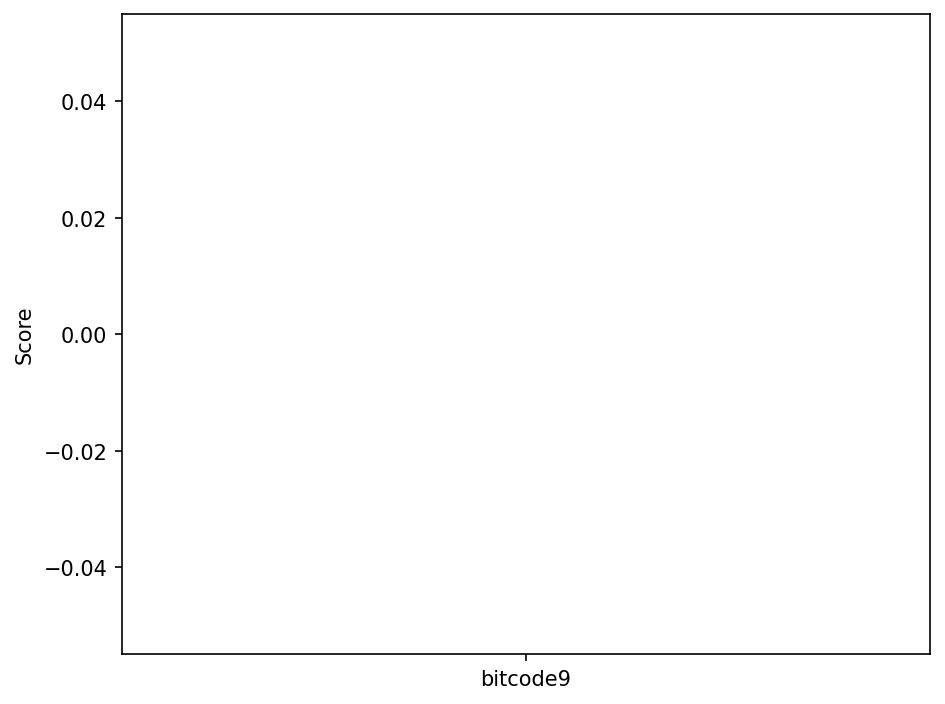

-----------------------------------------------------------
USED BACKEND:: fake_santiago ; CIRCUIT_NAME: bitcode9 ; SCORE = 0.0


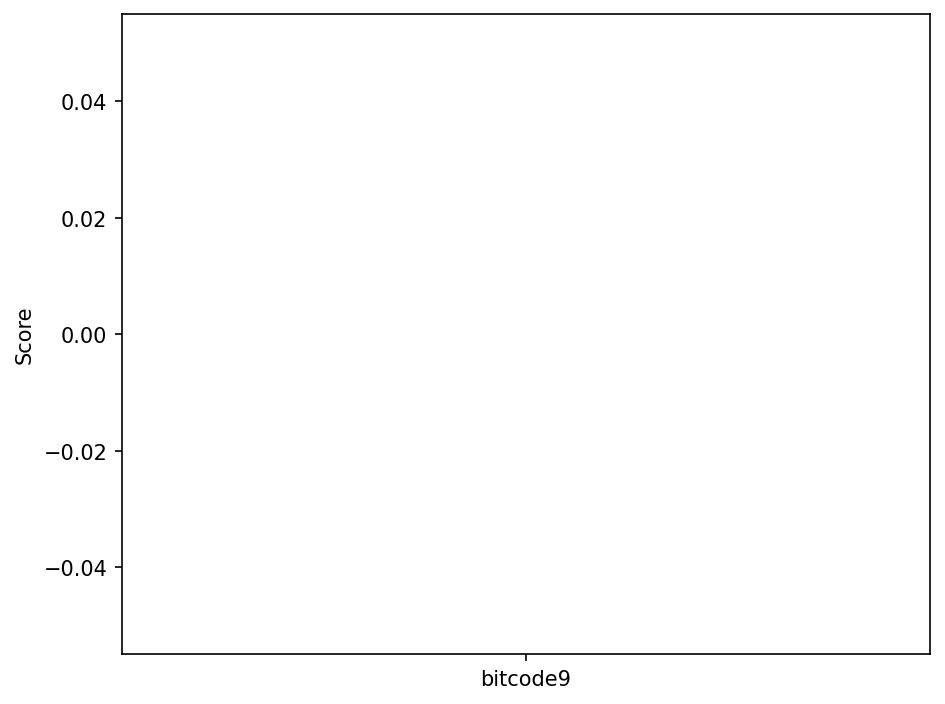

-----------------------------------------------------------
USED BACKEND:: fake_armonk ; CIRCUIT_NAME: bitcode9 ; SCORE = 0.0


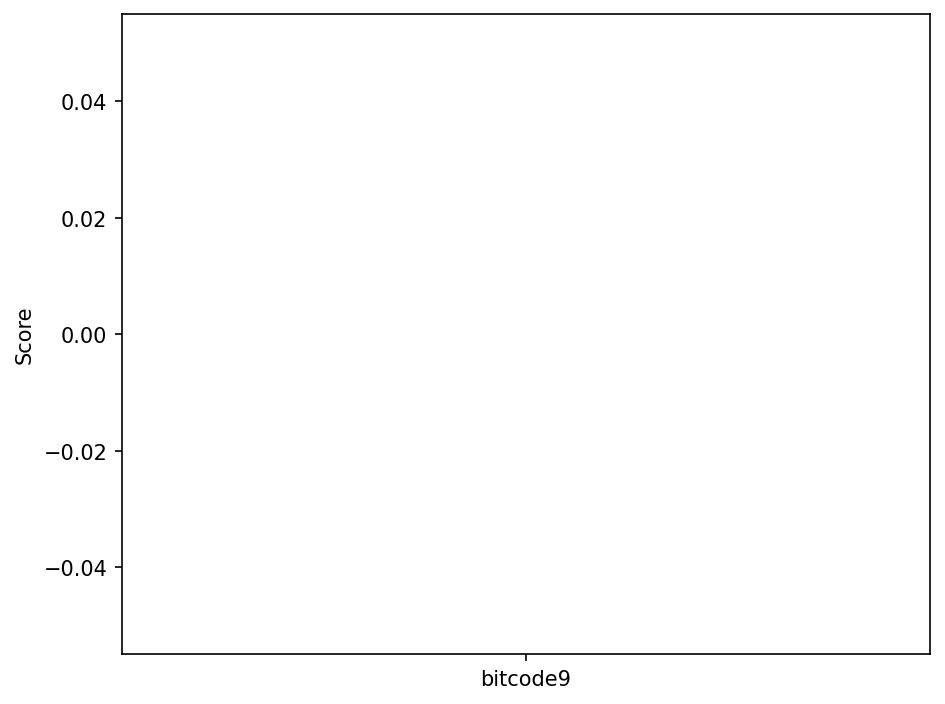

-----------------------------------------------------------
USED BACKEND:: fake_sherbrooke ; CIRCUIT_NAME: bitcode9 ; SCORE = 1.9721522630525295e-31


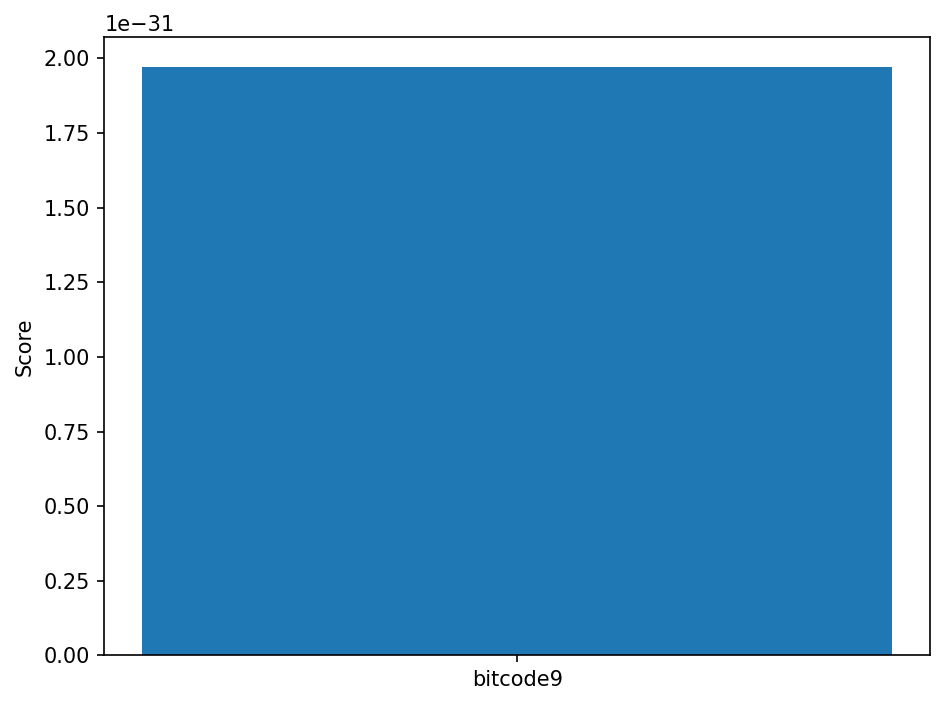

-----------------------------------------------------------


In [7]:
for label,benchmark,backend,job,score,sd in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    supermarq.plotting.plot_results([score], [label])
    print("-----------------------------------------------------------")

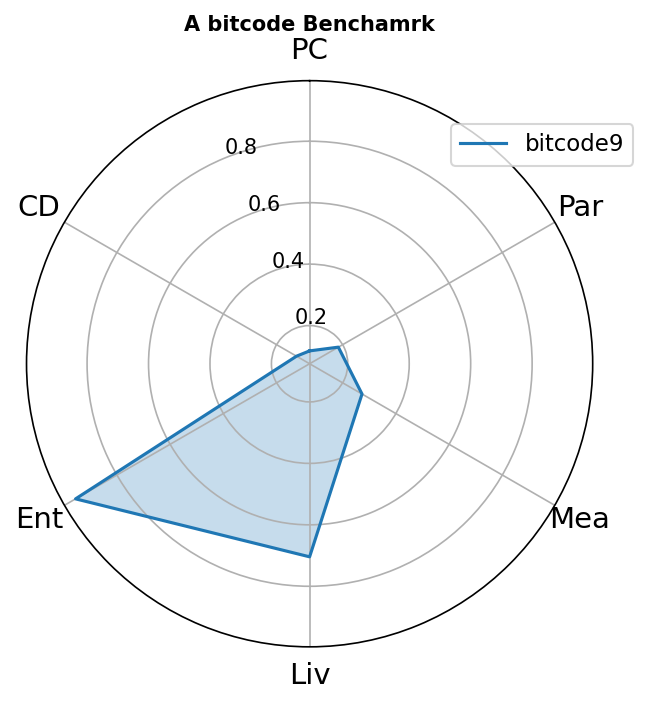

In [13]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
for i,j in benchmark_features.items():
    names.append(i)
    scores.append(j)
supermarq.plotting.plot_benchmark(
        [X,names,scores],
        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
        show=True)

/home/vandna/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vandna/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vandna/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vandna/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vandna/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with les

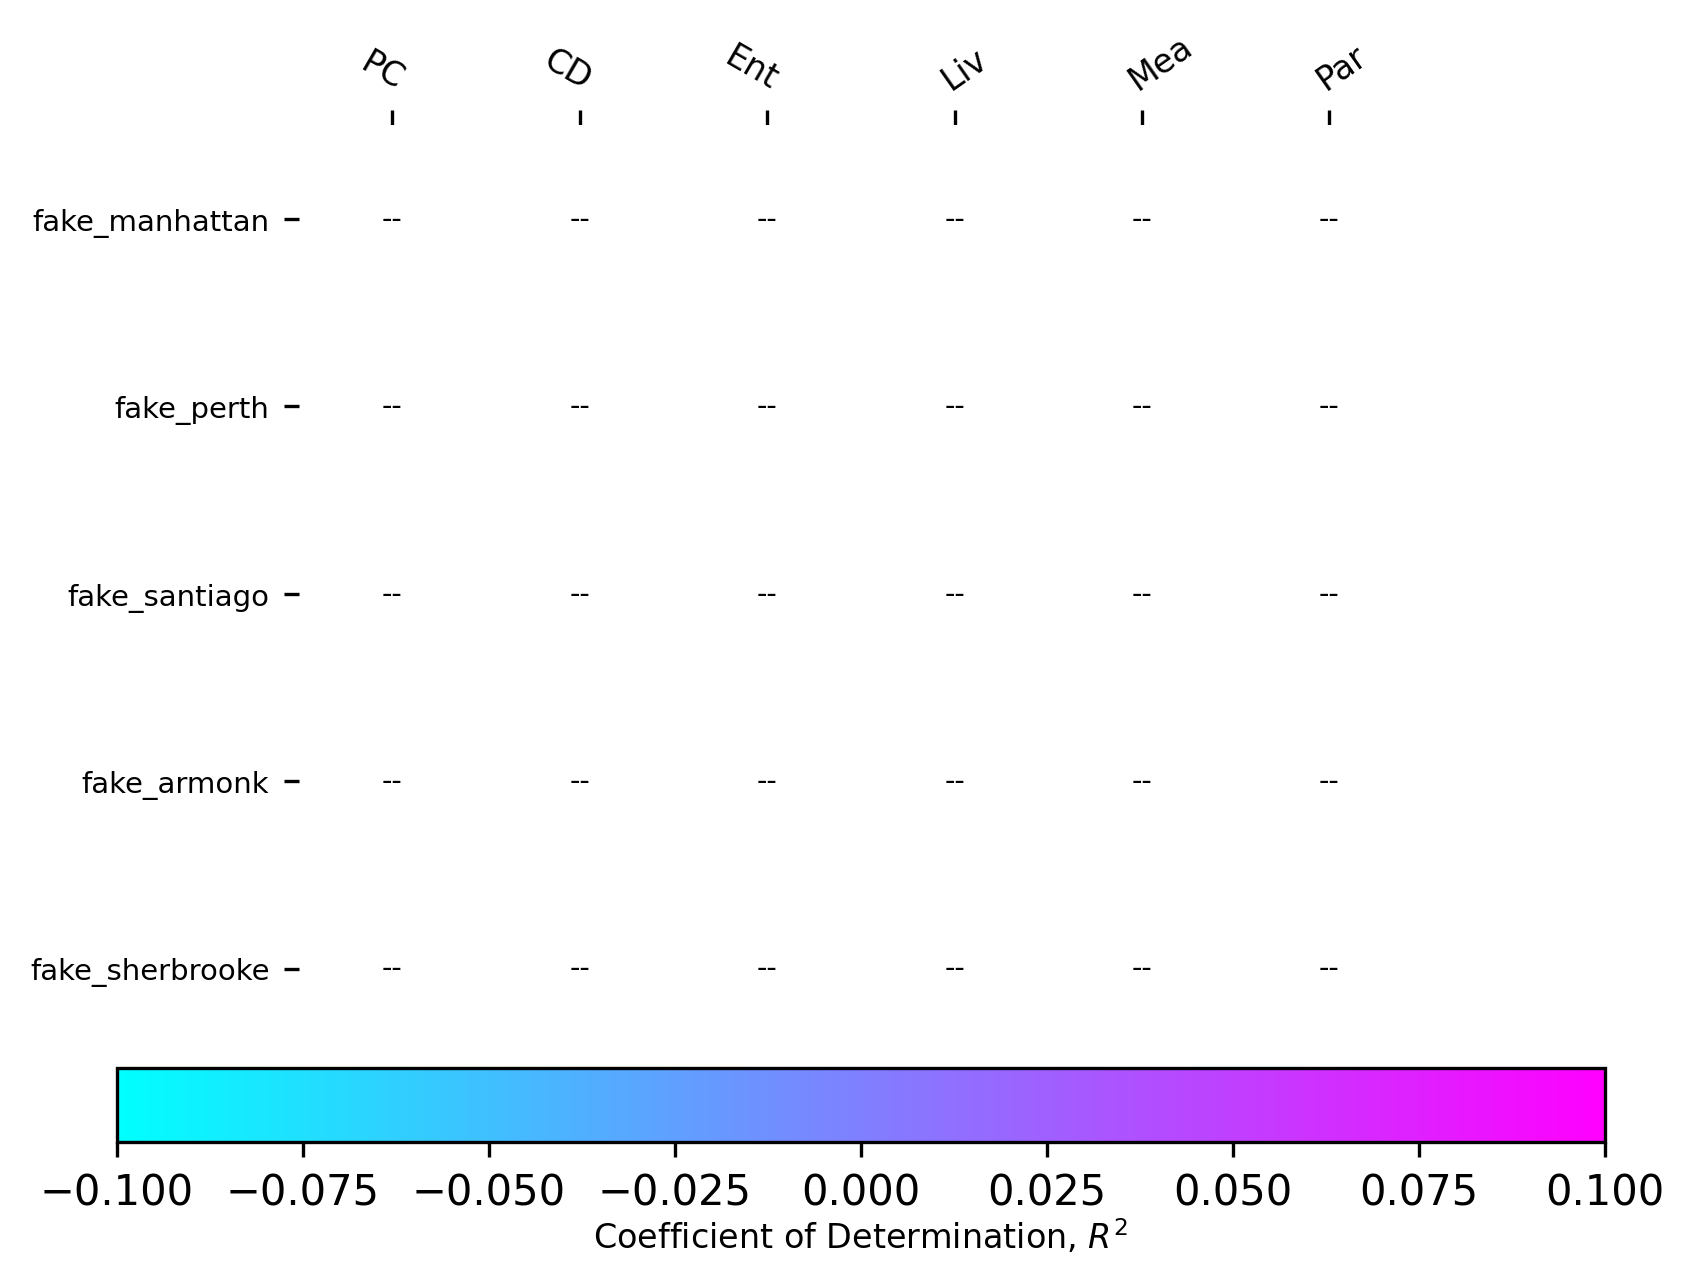

In [14]:
supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

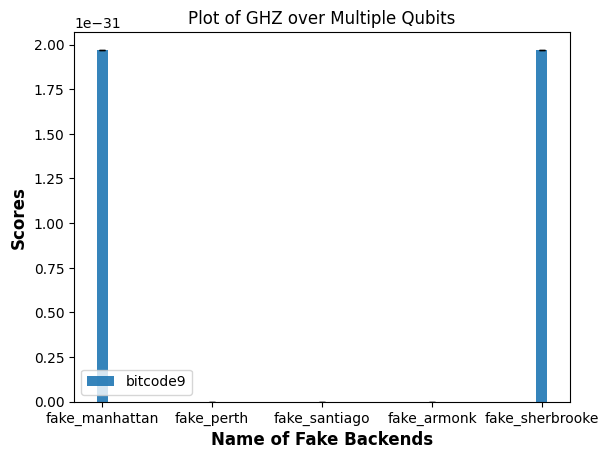

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title('Plot of GHZ over Multiple Qubits')
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()